<a href="https://colab.research.google.com/github/dorian68/BSpricer/blob/master/Pr%C3%A9visions_de_ventes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import threading
from concurrent.futures import ThreadPoolExecutor

# Décorateur pour mesurer le temps d'exécution
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Temps d'exécution de {func.__name__}: {end_time - start_time:.4f} secondes")
        return result
    return wrapper

# Fonction pour vérifier si un nombre est premier
def is_prime(n):
    if n < 2:
        return False
    if n == 2 or n == 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

# Fonction multithreadée pour générer les nombres premiers jusqu'à un max donné
@measure_time
def compute_primes(max_number, num_threads=6):
    primes = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(is_prime, range(2, max_number)))

    # Reconstruction des nombres premiers à partir des résultats
    primes = [num for num, is_p in zip(range(2, max_number), results) if is_p]
    print(f"Nombre de nombres premiers trouvés: {len(primes)}")
    return primes

# Test avec un grand nombre
if __name__ == "__main__":
    MAX_NUM = 10**6  # Nombre max à tester
    NUM_THREADS = threading.active_count() * 2  # Utilisation de plusieurs threads

    compute_primes(MAX_NUM, NUM_THREADS)


Nombre de nombres premiers trouvés: 78498
Temps d'exécution de compute_primes: 23.4982 secondes


In [ ]:
import backtrader as bt
import pandas as pd
from datetime import datetime, timedelta
import multiprocessing

class CryptoStrategy(bt.Strategy):
    params = (
        ("rsi_period", 14),
        ("rsi_lower", 30),
        ("rsi_upper", 70),
        ("boll_period", 20),
        ("adx_period", 14),
        ("atr_multiplier", 2),
        ("sma1_period", 15),
        ("sma2_period", 50),
    )

    def __init__(self):
        # Indicateurs techniques
        self.rsi = bt.indicators.RSI(period=self.params.rsi_period)
        self.boll = bt.indicators.BollingerBands(period=self.params.boll_period)
        self.adx = bt.indicators.ADX(period=self.params.adx_period)
        self.atr = bt.indicators.ATR(period=self.params.adx_period)
        self.sma1 = bt.indicators.SimpleMovingAverage(period=self.params.sma1_period)
        self.sma2 = bt.indicators.SimpleMovingAverage(period=self.params.sma2_period)

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt}, {txt}")

    def next(self):
        # Vérification si une position est déjà ouverte
        if self.position:
            if self.position.size > 0:  # Position longue
                if self.rsi > self.params.rsi_upper or self.data.close[0] < self.boll.lines.mid[0]:
                    self.log(f"CLOSE LONG @ {self.data.close[0]}")
                    self.close()
            elif self.position.size < 0:  # Position courte
                if self.rsi < self.params.rsi_lower or self.data.close[0] > self.boll.lines.mid[0]:
                    self.log(f"CLOSE SHORT @ {self.data.close[0]}")
                    self.close()
        else:
            if self.adx[0] > 25 and self.sma1[0] > self.sma2[0]:  # Tendance forte + croisement haussier
                if self.rsi < self.params.rsi_lower and self.data.close[0] < self.boll.lines.bot[0]:
                    stop_loss = self.data.close[0] - self.params.atr_multiplier * self.atr[0]
                    take_profit = self.data.close[0] + self.params.atr_multiplier * self.atr[0]
                    self.log(f"BUY @ {self.data.close[0]} | SL: {stop_loss} | TP: {take_profit}")
                    self.buy()
            elif self.adx[0] > 25 and self.sma1[0] < self.sma2[0]:  # Tendance forte + croisement baissier
                if self.rsi > self.params.rsi_upper and self.data.close[0] > self.boll.lines.top[0]:
                    stop_loss = self.data.close[0] + self.params.atr_multiplier * self.atr[0]
                    take_profit = self.data.close[0] - self.params.atr_multiplier * self.atr[0]
                    self.log(f"SELL @ {self.data.close[0]} | SL: {stop_loss} | TP: {take_profit}")
                    self.sell()

# Fonction de backtest pour exécuter plusieurs combinaisons de paramètres en parallèle
def run_backtest(params):
    cerebro = bt.Cerebro()
    data = bt.feeds.GenericCSVData(
        dataname=params["datafile"],
        dtformat="%d-%m-%Y %H:%M:%S",
        timeframe=bt.TimeFrame.Days,
        compression=1,
        openinterest=-1,
    )
    cerebro.adddata(data)
    strategy_params = {k: v for k, v in params.items() if k != "datafile"}
    cerebro.addstrategy(CryptoStrategy, **strategy_params)
    cerebro.broker.setcash(10000.0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.run()
    return cerebro.broker.getvalue()

import os
import tempfile
import requests

def get_local_file(datafile_url):
    # Si datafile est une URL, on télécharge le fichier
    if datafile_url.startswith("http"):
        response = requests.get(datafile_url)
        if response.status_code != 200:
            raise Exception(f"Erreur lors du téléchargement du fichier : {datafile_url}")
        # Créer un fichier temporaire pour sauvegarder le CSV
        tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".csv")
        tmp.write(response.content)
        tmp.close()
        return tmp.name
    else:
        # Sinon, c'est déjà un chemin local
        return datafile_url


# Exécuter plusieurs backtests en parallèle
def optimize_backtest(datafile):
    local_datafile = get_local_file(datafile)
    print(local_datafile)
    param_grid = [
        {"rsi_period": rsi, "boll_period": boll, "adx_period": adx, "datafile": local_datafile}
        for rsi in [12, 14, 16]
        for boll in [18, 20, 22]
        for adx in [12, 14, 16]
    ]

    with multiprocessing.Pool(processes=8) as pool:
        results = pool.map(run_backtest, param_grid)

    print("Optimisation terminée. Résultats :", results)
    return results

# Lancer l'optimisation (fichier CSV requis)
# Exemple : optimize_backtest("bitcoin_data.csv")

In [ ]:
path = "https://raw.githubusercontent.com/dorian68/repo_data/refs/heads/main/bitstampUSD_1-min_data_01-04-2018_to_14-04-2018.csv"

df_data = pd.read_csv(path)
df_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,31-03-2018 22:01:00,6929.40,6942.10,6929.40,6942.10,5.513125,38219.895791,6932.528919
1,31-03-2018 22:02:00,6935.99,6935.99,6935.99,6935.99,0.024279,168.399942,6935.990000
2,31-03-2018 22:03:00,6935.98,6935.99,6935.98,6935.99,0.119066,825.841026,6935.983212
3,31-03-2018 22:04:00,6935.99,6935.99,6935.99,6935.99,0.011681,81.019507,6935.990000
4,31-03-2018 22:05:00,6925.10,6935.99,6925.10,6925.10,0.031262,216.657493,6930.460534


In [ ]:
res = optimize_backtest(path);

NameError: name 'optimize_backtest' is not defined

In [ ]:
pip install pandas backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 13.5 MB/s eta 0:00:00


In [ ]:
res

NameError: name 'res' is not defined

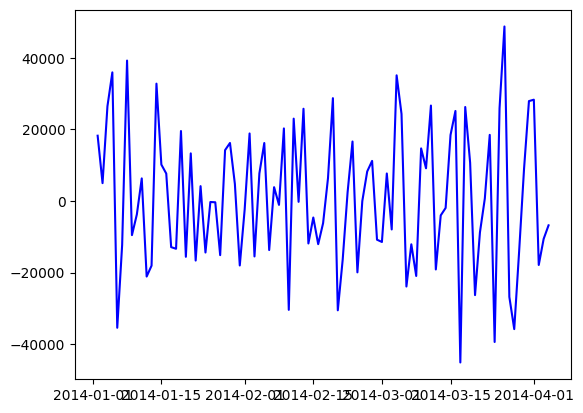

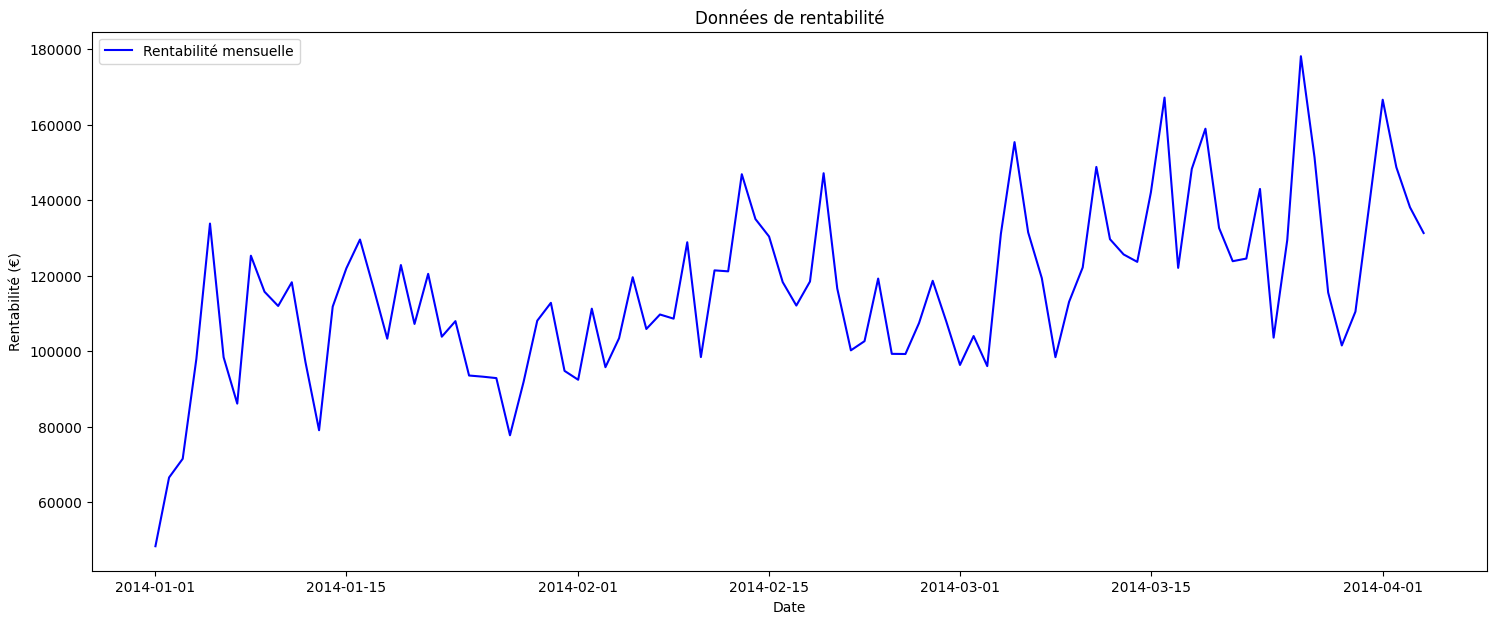

La série n'est pas stationnaire
Vérification des NaN : price    0
dtype: int64


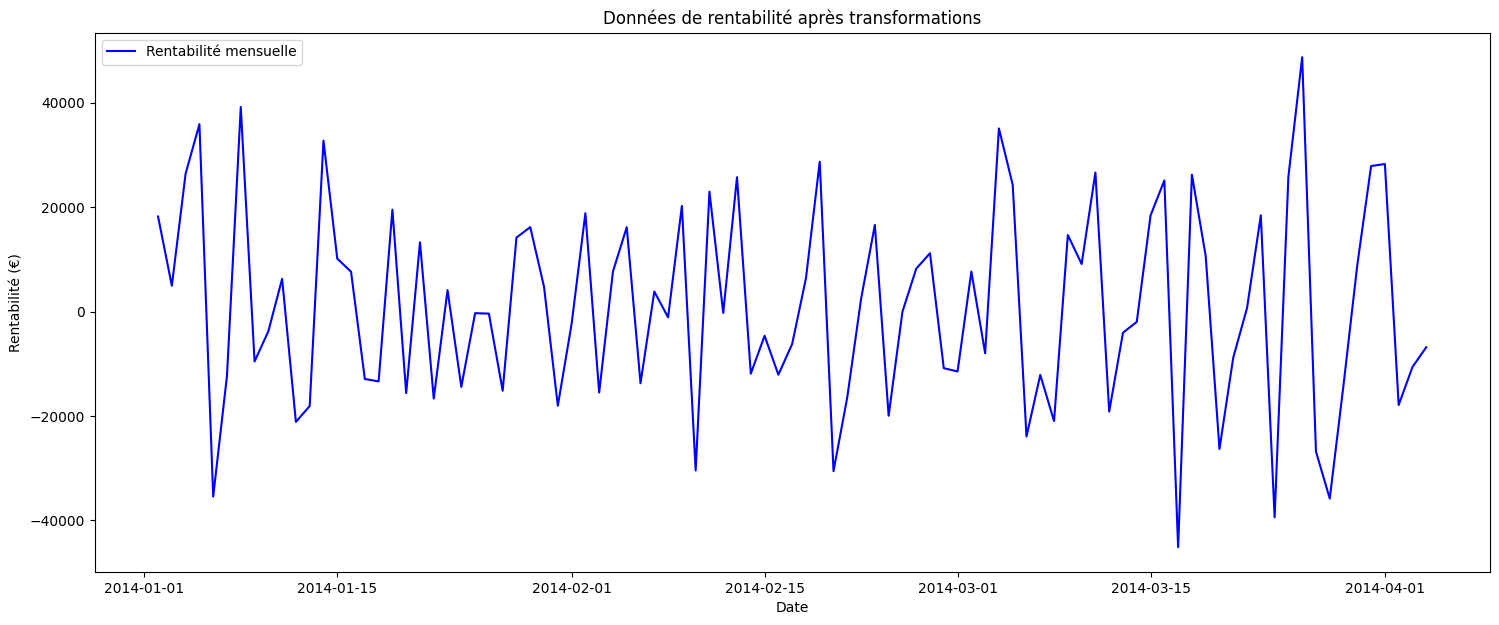

NaN dans l'ensemble d'entraînement : price    0
dtype: int64
NaN dans l'ensemble de test : price    0
dtype: int64


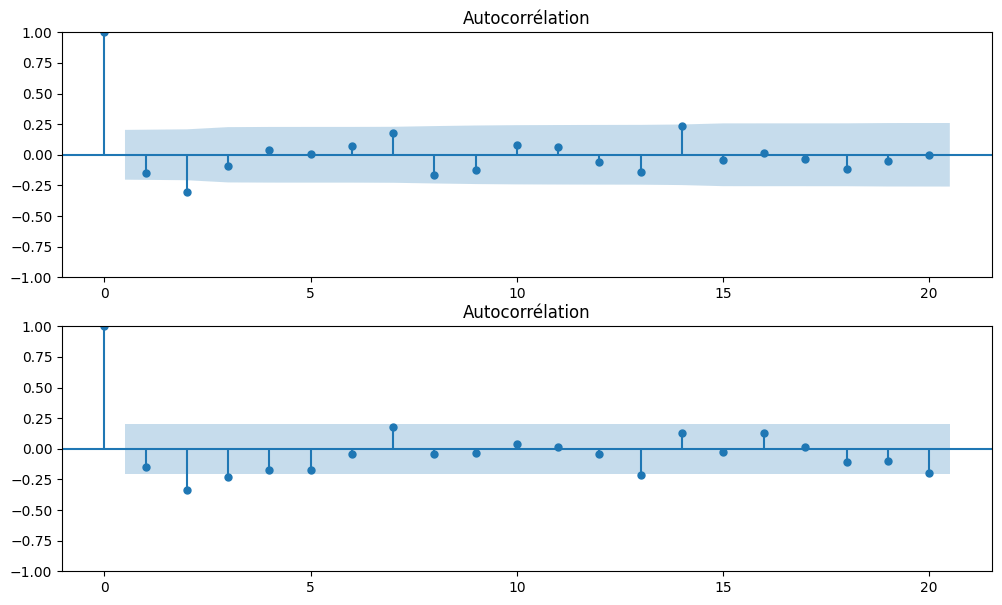

----------------------------------------
(p, d, q) = (74, 1, 74)
----------------------------------------
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   74
Model:               ARIMA(74, 1, 74)   Log Likelihood                -792.704
Date:                Tue, 18 Feb 2025   AIC                           1883.407
Time:                        00:47:42   BIC                           2224.686
Sample:                    01-02-2014   HQIC                          2019.413
                         - 03-16-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9017      7.756     -0.116      0.907     -16.104      14.300
ar.L2         -0.5494    

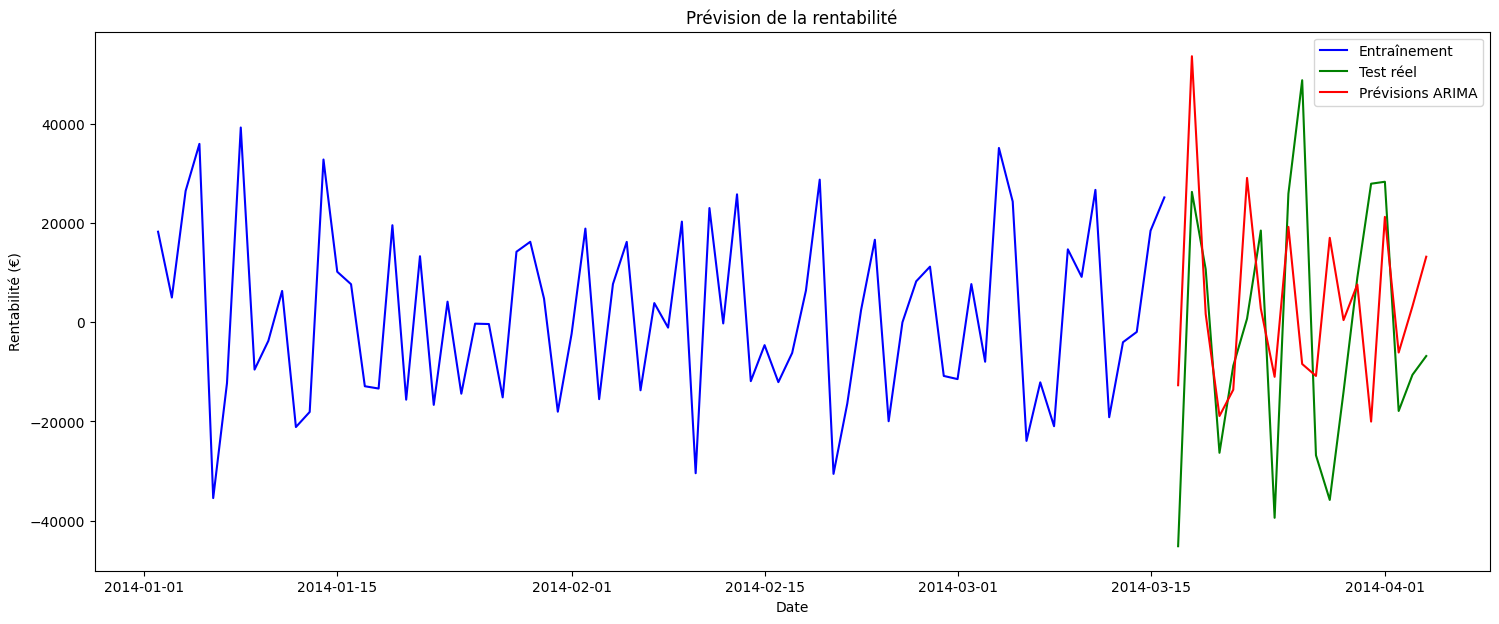

Erreur quadratique moyenne (MSE) : 707983535.18


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import pickle

# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us

# Charger les données
#df_sales = pd.read_csv(r"C:\Users\Do\Downloads\archive (1)\orders_train.txt", sep=";")
df_sales = pd.read_csv("https://raw.githubusercontent.com/dorian68/repo_data/refs/heads/main/orders_train2014-04-05.txt")

# Agréger les données de vente par date
tcd_sales = pd.pivot_table(df_sales, index=['orderDate'], values=['price'], aggfunc=sum)
df_sales = tcd_sales.reset_index()
df_sales.set_index('orderDate', inplace=True)

# Nettoyage des données
data = df_sales
data = data.dropna()  # Supprime les NaN
data.index = pd.to_datetime(data.index)  # Convertit l'index en datetime

# Visualisation des données initiales
plt.figure(figsize=(18, 7))
plt.plot(data, label="Rentabilité mensuelle", color="blue")
plt.title("Données de rentabilité")
plt.xlabel("Date")
plt.ylabel("Rentabilité (€)")
plt.legend()
plt.show()

# Test ADF pour vérifier la stationnarité (Test de Dickey-Fuller Augmenté)
result = adfuller(data['price'])
p_value = result[1]
if p_value > 0.05:  # Si la série n'est pas stationnaire
    print("La série n'est pas stationnaire")
    data = data.diff().dropna()  # Différencie et supprime les NaN
else:
    print("La série est stationnaire")

# Vérification des NaN après transformation
print("Vérification des NaN :", data.isna().sum())

# Diminue l'amplitude des mouvements de la série
scaler = StandardScaler()
data_array = data["price"].values
train_scaled = scaler.fit_transform(data_array.reshape(-1, 1))
data["price"] = data_array

# Visualisation des données après transformations
plt.figure(figsize=(18, 7))
plt.plot(data, label="Rentabilité mensuelle", color="blue")
plt.title("Données de rentabilité après transformations")
plt.xlabel("Date")
plt.ylabel("Rentabilité (€)")
plt.legend()
plt.show()

# Division des données en ensemble d'entraînement et de test
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Vérification des NaN dans les ensembles d'entraînement et de test
print("NaN dans l'ensemble d'entraînement :", train.isna().sum())
print("NaN dans l'ensemble de test :", test.isna().sum())

# Analyse ACF/PACF
nb_lags=20
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plot_acf(data, ax=axes[0], lags=nb_lags, title="Autocorrélation")
plot_pacf(data, ax=axes[1], lags=nb_lags, title="Autocorrélation")
plt.show()

# Entraînement du modèle ARIMA
p = int(train_size)
d = 1
q = int(train_size)
model = ARIMA(train["price"], order=(p,d,q))  # Ajustez (p, d, q) selon vos besoins
print('----------------------------------------')
print(f"(p, d, q) = {p,d,q}")
print('----------------------------------------')

#initialize the statespace differently
model.initialize_approximate_diffuse()
model_fit = model.fit()

# Sauvegarde du modèle ARIMA
with open("arima_model.pkl", "wb") as f:
    pickle.dump(model_fit, f)

# Chargement ultérieur du modèle
#with open("arima_model.pkl", "rb") as f:
#    loaded_arima = pickle.load(f)

# Affichage du résumé du modèle
print(model_fit.summary())

# Prévision pour la période de test
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Visualisation des résultats
plt.figure(figsize=(18, 7))
plt.plot(train, label="Entraînement", color="blue")
plt.plot(test, label="Test réel", color="green")
plt.plot(forecast, label="Prévisions ARIMA", color="red")
plt.title("Prévision de la rentabilité")
plt.xlabel("Date")
plt.ylabel("Rentabilité (€)")
plt.legend()
plt.show()

# Évaluation des performances du modèle
mse = mean_squared_error(test, forecast)
print(f"Erreur quadratique moyenne (MSE) : {mse:.2f}")
# DOCUMENTATION
# https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/
# https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html
# https://www.ibm.com/fr-fr/topics/arima-model

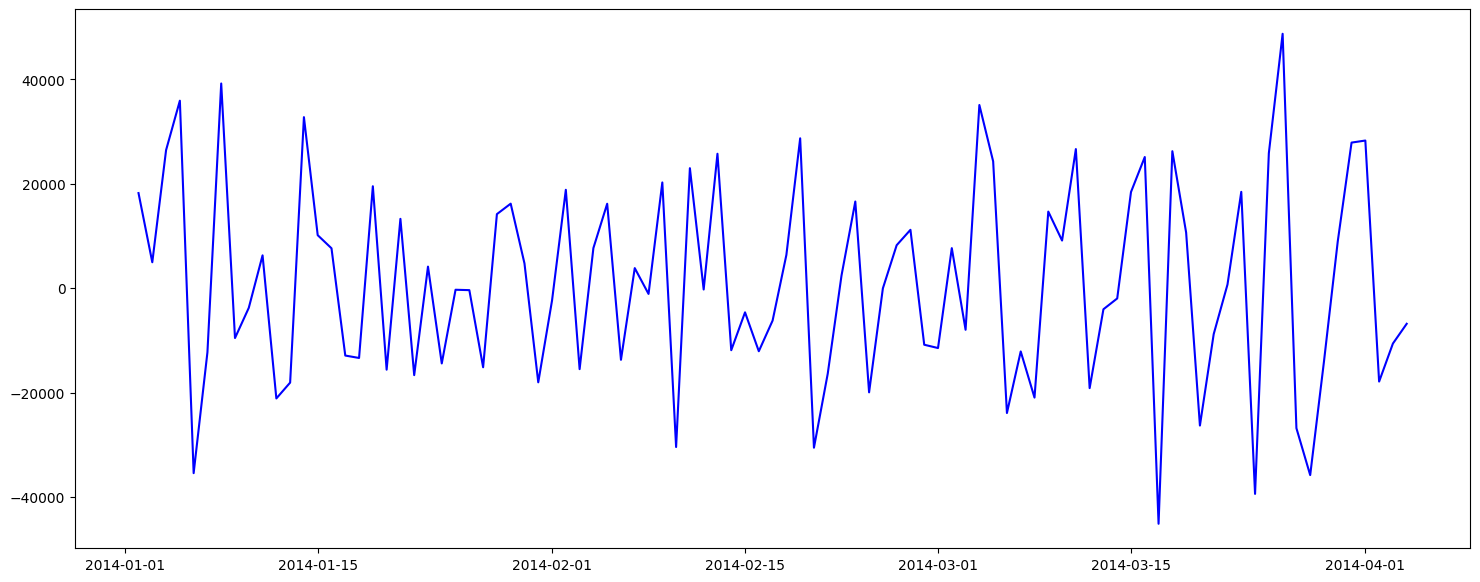

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(data, label="Test réel", color="blue")

Analyse des résidus

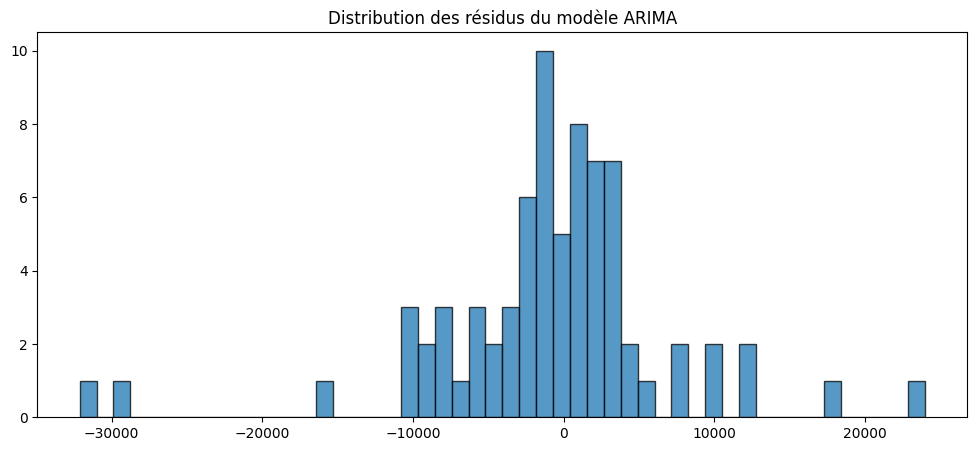

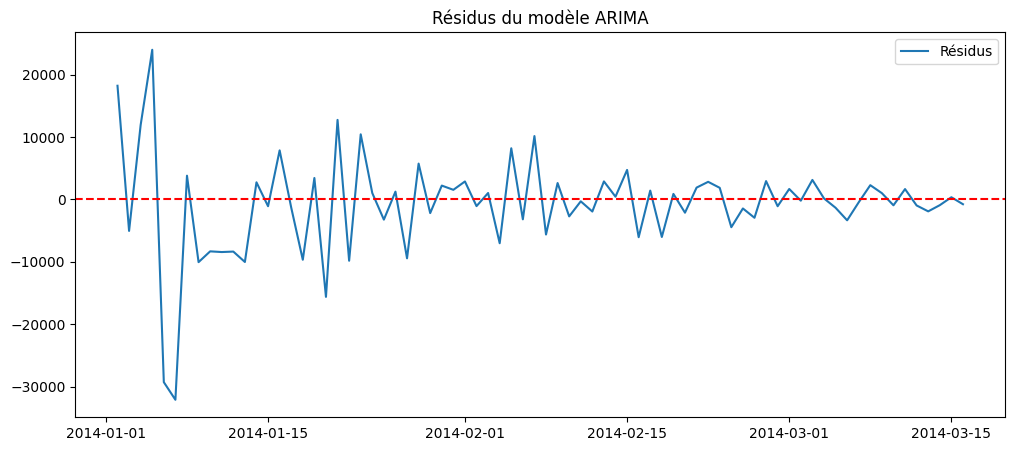

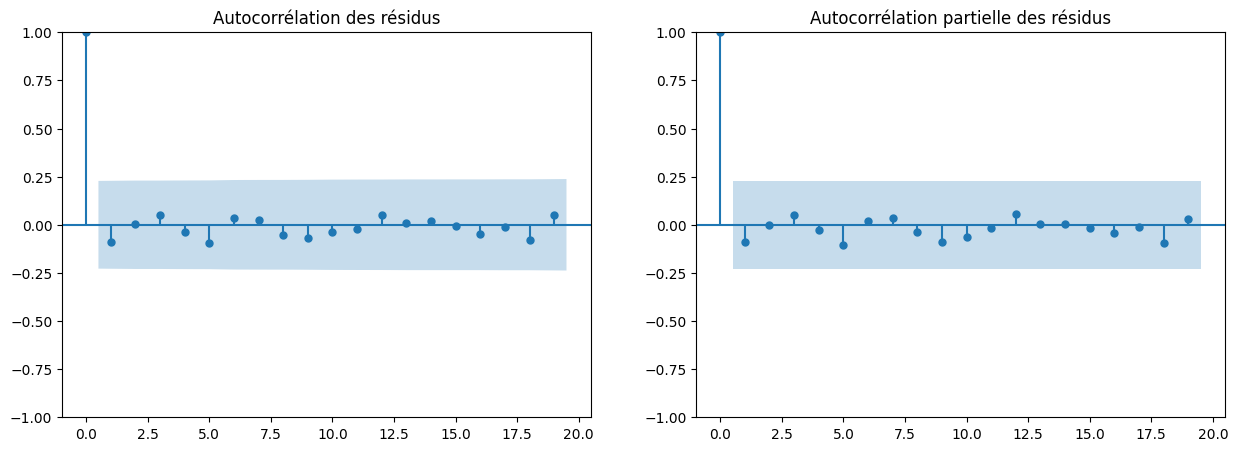

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Récupération des résidus
residuals = model_fit.resid

# Tracé de la distribution des résidus
plt.figure(figsize=(12, 5))
plt.hist(residuals, bins=50, alpha=0.75, edgecolor="black")
plt.title("Distribution des résidus du modèle ARIMA")
plt.show()

# Tracé de la série temporelle des résidus
plt.figure(figsize=(12, 5))
plt.plot(residuals, label="Résidus")
plt.axhline(y=0, color='r', linestyle='dashed')
plt.legend()
plt.title("Résidus du modèle ARIMA")
plt.show()

# Analyse ACF/PACF des résidus (doivent être proches de bruit blanc)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(residuals, ax=axes[0], title="Autocorrélation des résidus")
plot_pacf(residuals, ax=axes[1], title="Autocorrélation partielle des résidus")
plt.show()

In [ ]:
# Test ADF pour vérifier la stationnarité (Test de Dickey-Fuller Augmenté)
result = adfuller(residuals)
p_value = result[1]
if p_value > 0.05:  # Si la série n'est pas stationnaire
    print("La série n'est pas stationnaire")
    data = data.diff().dropna()  # Différencie et supprime les NaN
else:
    print("La série est stationnaire")

La série est stationnaire


Iteration:      1,   Func. Count:      7,   Neg. LLF: 2438.639506317412
Iteration:      2,   Func. Count:     14,   Neg. LLF: 738.0590656201558
Iteration:      3,   Func. Count:     22,   Neg. LLF: 736.0936213917817
Iteration:      4,   Func. Count:     28,   Neg. LLF: 736.0743554102064
Iteration:      5,   Func. Count:     34,   Neg. LLF: 736.0348213264318
Iteration:      6,   Func. Count:     40,   Neg. LLF: 736.0340655783597
Iteration:      7,   Func. Count:     46,   Neg. LLF: 736.0340403249634
Iteration:      8,   Func. Count:     52,   Neg. LLF: 736.0338788296957
Iteration:      9,   Func. Count:     58,   Neg. LLF: 736.0329826707693
Iteration:     10,   Func. Count:     64,   Neg. LLF: 736.0282233705765
Iteration:     11,   Func. Count:     70,   Neg. LLF: 736.0034500306118
Iteration:     12,   Func. Count:     76,   Neg. LLF: 735.8781043960959
Iteration:     13,   Func. Count:     82,   Neg. LLF: 735.3183671549394
Iteration:     14,   Func. Count:     88,   Neg. LLF: 734.553598

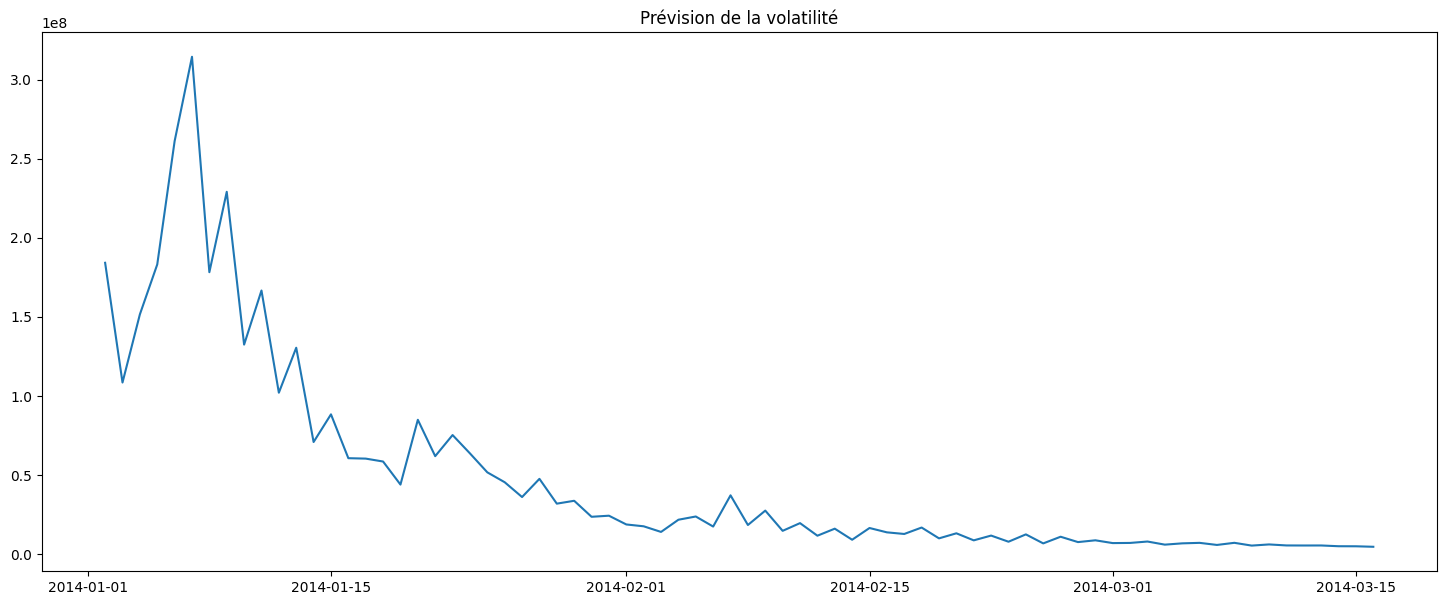

In [ ]:
# Modèle GARCH simple avec une loi normale
from arch import arch_model

# Apply GARCH model on ARIMA residuals
arch_model_fit = arch_model(residuals, vol='Garch', p=1, q=2)
garch_fit = arch_model_fit.fit()

# Sauvegarde du modèle GARCH
with open("garch_model.pkl", "wb") as f:
    pickle.dump(arch_model, f)

# Chargement ultérieur du modèle
#with open("garch_model.pkl", "rb") as f:
#    loaded_garch = pickle.load(f)

# Résumé du modèle GARCH
print(garch_fit.summary())

# Prédiction de la volatilité
garch_forecast = garch_fit.forecast(start=0)
plt.figure(figsize=(18,7))
plt.plot(garch_forecast.variance)
plt.title('Prévision de la volatilité')
plt.show()

In [ ]:
# Utilisation d'un model GARCH pour capter la volatilité des résidus

In [ ]:
#Prévisions GARCH

In [ ]:
# Prévisions de la volatilité pour les étapes suivantes
garch_forecast = garch_fit.forecast(horizon=len(forecast))  # Prévisions de la volatilité sur 10 étapes

# Extraction de la variance (volatilité)
volatility_forecast = garch_forecast.variance.values[-1, :]
print(volatility_forecast)

[4751906.35854309 5556415.87846242 5499866.3589116  6025438.39472019
 6086259.17114303 6447930.16423335 6556253.04858049 6817594.38608811
 6938770.48285206 7135655.48995772 7253316.57381124 7406585.37066882
 7513728.80891034 7635957.93210655 7730274.00528274 7829412.26493054
 7910851.49906874 7992187.16412655 8061707.77368708]


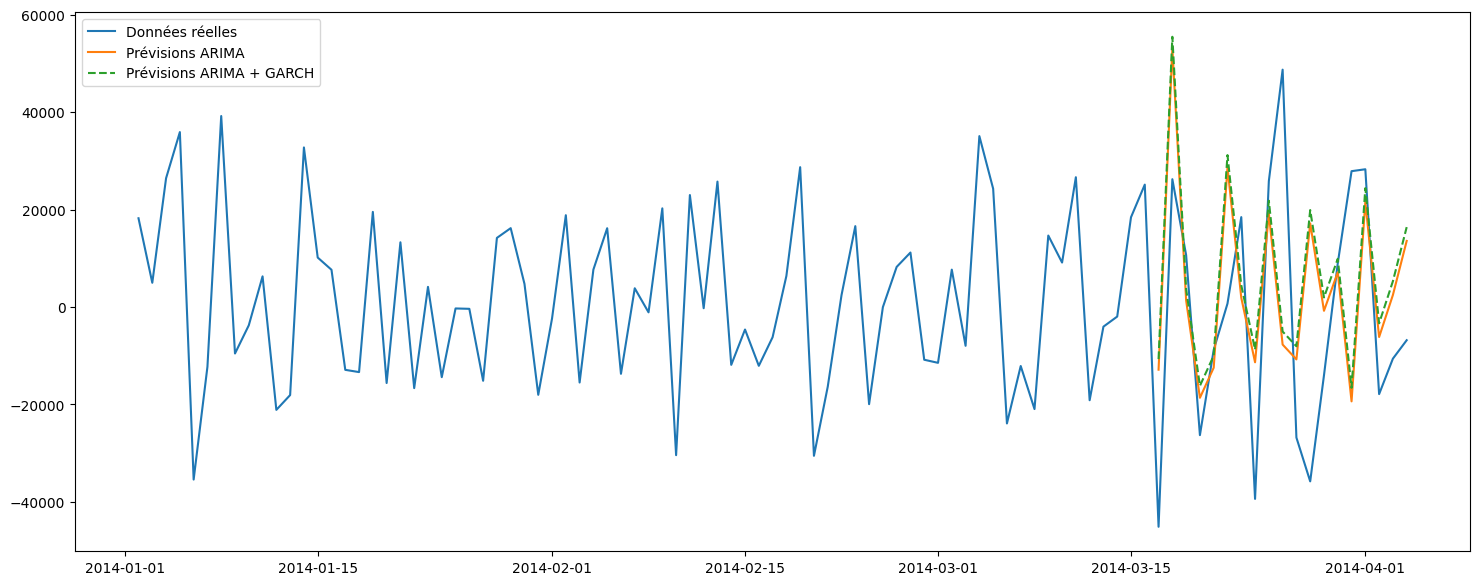

In [ ]:
# Combinez les prévisions du modèle ARIMA et de la volatilité du modèle GARCH
combined_forecast = forecast + volatility_forecast**0.5  # Ajout de la racine carrée de la variance pour la volatilité

# Visualisation des prévisions combinées
plt.figure(figsize=(18,7))
plt.plot( data, label='Données réelles')
plt.plot( forecast, label='Prévisions ARIMA')
plt.plot(combined_forecast, label='Prévisions ARIMA + GARCH', linestyle='--')
plt.legend()
plt.show()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1040.91856670093
Iteration:      2,   Func. Count:     16,   Neg. LLF: 737.9581594172497
Iteration:      3,   Func. Count:     24,   Neg. LLF: 736.3897476277451
Iteration:      4,   Func. Count:     31,   Neg. LLF: 736.3633622929109
Iteration:      5,   Func. Count:     38,   Neg. LLF: 736.3519164959677
Iteration:      6,   Func. Count:     45,   Neg. LLF: 736.3410068864223
Iteration:      7,   Func. Count:     52,   Neg. LLF: 736.3390589521867
Iteration:      8,   Func. Count:     59,   Neg. LLF: 736.3280179231916
Iteration:      9,   Func. Count:     66,   Neg. LLF: 736.2811079780724
Iteration:     10,   Func. Count:     73,   Neg. LLF: 736.1912080275548
Iteration:     11,   Func. Count:     80,   Neg. LLF: 736.1474438311626
Iteration:     12,   Func. Count:     87,   Neg. LLF: 736.1087103636229
Iteration:     13,   Func. Count:     94,   Neg. LLF: 736.0781708586293
Iteration:     14,   Func. Count:    101,   Neg. LLF: 736.0518384

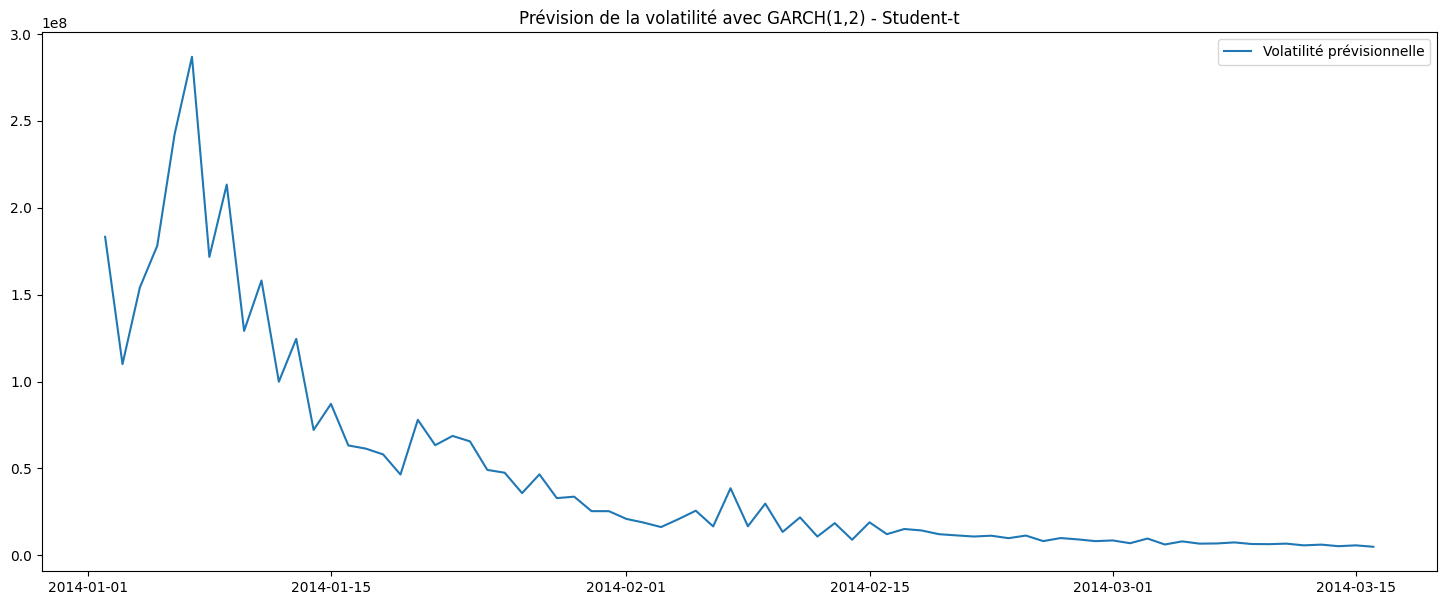

In [ ]:
# GARCH + loi de student
import pickle
import matplotlib.pyplot as plt
from arch import arch_model

# Modèle GARCH(1,2) avec une distribution de student-t
garch_model = arch_model(residuals, vol='Garch', p=1, q=2, dist='t')
garch_fit = garch_model.fit()

# Sauvegarde du modèle
with open("garch_model.pkl", "wb") as f:
  pickle.dump(garch_fit,f)

# Résumé du modèle
print(garch_fit.summary())

# Prédiction de la volatilité
garch_forecast = garch_fit.forecast(start=0)

plt.figure(figsize=(18,7))
plt.plot(garch_forecast.variance, label="Volatilité prévisionnelle")
plt.legend()
plt.title('Prévision de la volatilité avec GARCH(1,2) - Student-t')
plt.show()

In [ ]:
def ARIMA_plus_XARCH(forecast_ARIMA,garch_fit):
  # Prévisions de la volatilité pour les étapes suivantes
  garch_forecast = garch_fit.forecast(horizon=len(forecast))  # Prévisions de la volatilité sur 10 étapes

  # Extraction de la variance (volatilité)
  volatility_forecast = garch_forecast.variance.values[-1, :]
  print(volatility_forecast)

  # Combinez les prévisions du modèle ARIMA et de la volatilité du modèle GARCH
  combined_forecast = forecast + volatility_forecast ** 0.5  # Ajout de la racine carrée de la variance pour la volatilité

  # Visualisation des prévisions combinées
  plt.figure(figsize=(18,7))
  plt.plot( data, label='Données réelles')
  plt.plot( forecast, label='Prévisions ARIMA')
  plt.plot(combined_forecast, label='Prévisions ARIMA + GARCH', linestyle='--')
  plt.legend()
  plt.show()

[4751906.35854309 5556415.87846242 5499866.3589116  6025438.39472019
 6086259.17114303 6447930.16423335 6556253.04858049 6817594.38608811
 6938770.48285206 7135655.48995772 7253316.57381124 7406585.37066882
 7513728.80891034 7635957.93210655 7730274.00528274 7829412.26493054
 7910851.49906874 7992187.16412655 8061707.77368708]


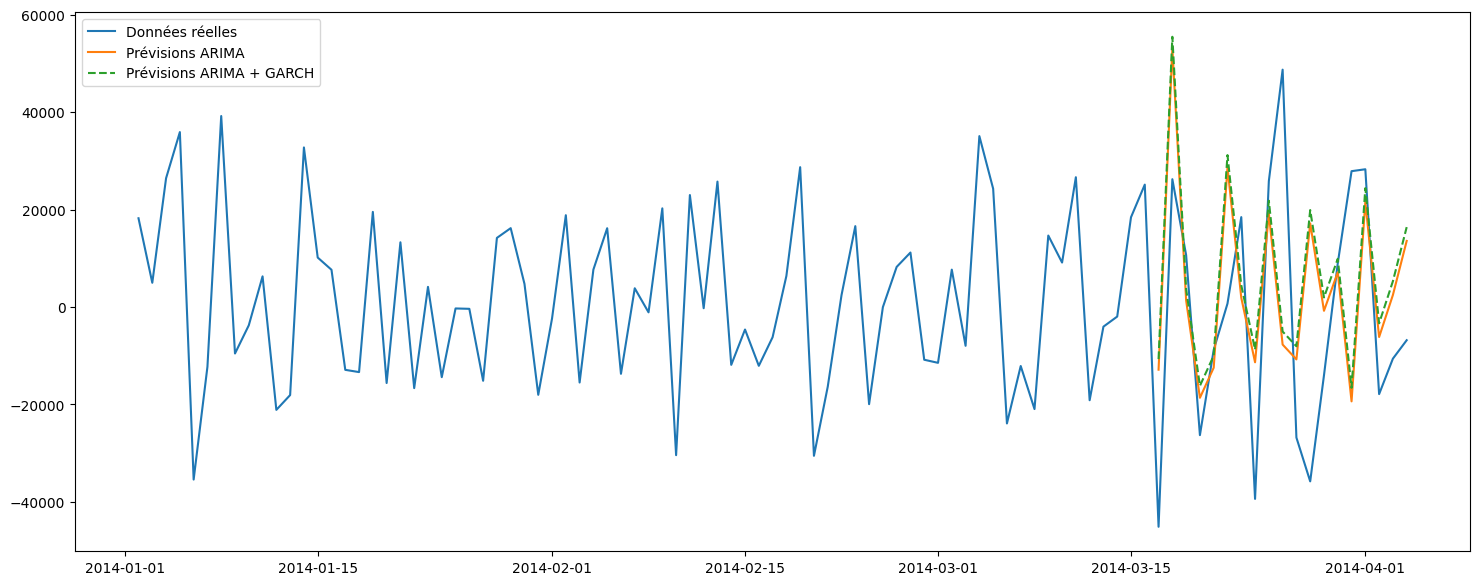

In [ ]:
ARIMA_plus_XARCH(forecast,garch_fit)

In [ ]:
# Implémentation de modèle GJR-GARCH

gjr_garch_model = arch_model(residuals, vol = 'Garch', p=200, q=200, o=200, dist='t')
gjr_garch_fit = gjr_garch_model.fit()

# Résumé du modèle
print(gjr_garch_fit.summary())

# Prédiction de la volatilité
gjr_garch_forecast = gjr_garch_fit.forecast(start=0)

plt.figure(figsize=(18,7))
plt.plot(gjr_garch_forecast.variance, label="Volatilité prévisionnelle")
plt.legend()
plt.title('Prévision de la volatilité avec GJR-GARCH(1,2) - Student-t')
plt.show()

Iteration:      1,   Func. Count:    605,   Neg. LLF: 747.5550810395857
Iteration:      2,   Func. Count: 1.21e+03,   Neg. LLF: 783.7138651451954
Iteration:      3,   Func. Count: 1.81e+03,   Neg. LLF: 784.4616415677613
Iteration:      4,   Func. Count: 2.42e+03,   Neg. LLF: 762.6482886793592
Iteration:      5,   Func. Count: 3.03e+03,   Neg. LLF: 780.460016717953
Iteration:      6,   Func. Count: 3.63e+03,   Neg. LLF: 776.627014879454
Iteration:      7,   Func. Count: 4.24e+03,   Neg. LLF: 775.1539805776396
Iteration:      8,   Func. Count: 4.84e+03,   Neg. LLF: 778.5409996301809
Iteration:      9,   Func. Count: 5.45e+03,   Neg. LLF: 774.9669530445885
Iteration:     10,   Func. Count: 6.05e+03,   Neg. LLF: 772.7712454563144
Iteration:     11,   Func. Count: 6.66e+03,   Neg. LLF: 775.0958517741751
Iteration:     12,   Func. Count: 7.26e+03,   Neg. LLF: 773.1590120479553
Iteration:     13,   Func. Count: 7.87e+03,   Neg. LLF: 740.6274651865888
Iteration:     14,   Func. Count: 8.47e+03

LinAlgError: Singular matrix

[38728775.14571273 35218131.76973146 53388185.54851387 51305047.64081844
 52183043.12193652 56361680.54805135 53585843.21440563 56842407.6309731
 57905067.43517192 56561318.05655231 59554707.16950998 63475179.97028597
 62727293.78702012 67633097.72208741 70308164.4899559  71760308.60003908
 82094836.62287937 83245320.4634886  90908060.3080638 ]


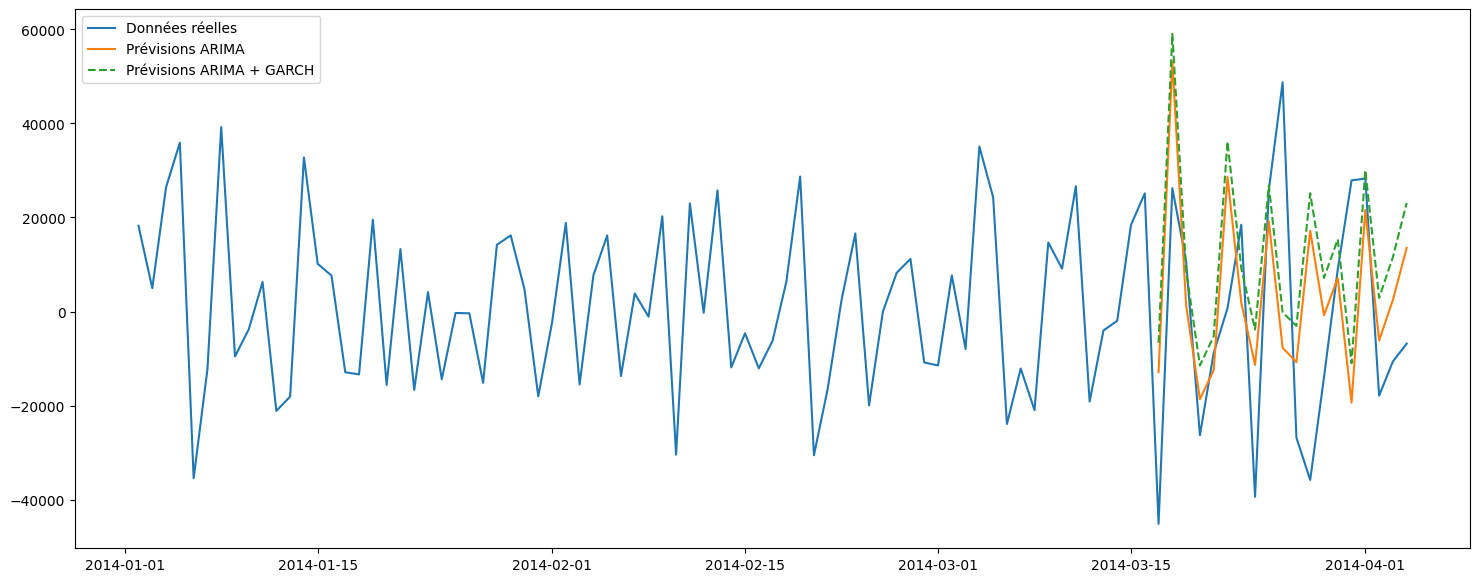

In [ ]:
ARIMA_plus_XARCH(forecast,gjr_garch_fit)

Iteration:      1,   Func. Count:    206,   Neg. LLF: 2156.7085459678415
Iteration:      2,   Func. Count:    412,   Neg. LLF: 818.6378020567488
Iteration:      3,   Func. Count:    618,   Neg. LLF: 996.5131398999099
Iteration:      4,   Func. Count:    824,   Neg. LLF: 826.3769702321896
Iteration:      5,   Func. Count: 1.03e+03,   Neg. LLF: 746.6174506496491
Iteration:      6,   Func. Count: 1.24e+03,   Neg. LLF: 746.8235585464869
Iteration:      7,   Func. Count: 1.44e+03,   Neg. LLF: 757.7340874549487
Iteration:      8,   Func. Count: 1.65e+03,   Neg. LLF: 742.5441428816927
Iteration:      9,   Func. Count: 1.85e+03,   Neg. LLF: 732.9624395603698
Iteration:     10,   Func. Count: 2.06e+03,   Neg. LLF: 742.8423584372061
Iteration:     11,   Func. Count: 2.27e+03,   Neg. LLF: 762.7827851470345
Iteration:     12,   Func. Count: 2.47e+03,   Neg. LLF: 743.9152255411948
Iteration:     13,   Func. Count: 2.68e+03,   Neg. LLF: 737.4075650854204
Iteration:     14,   Func. Count: 2.88e+03,  

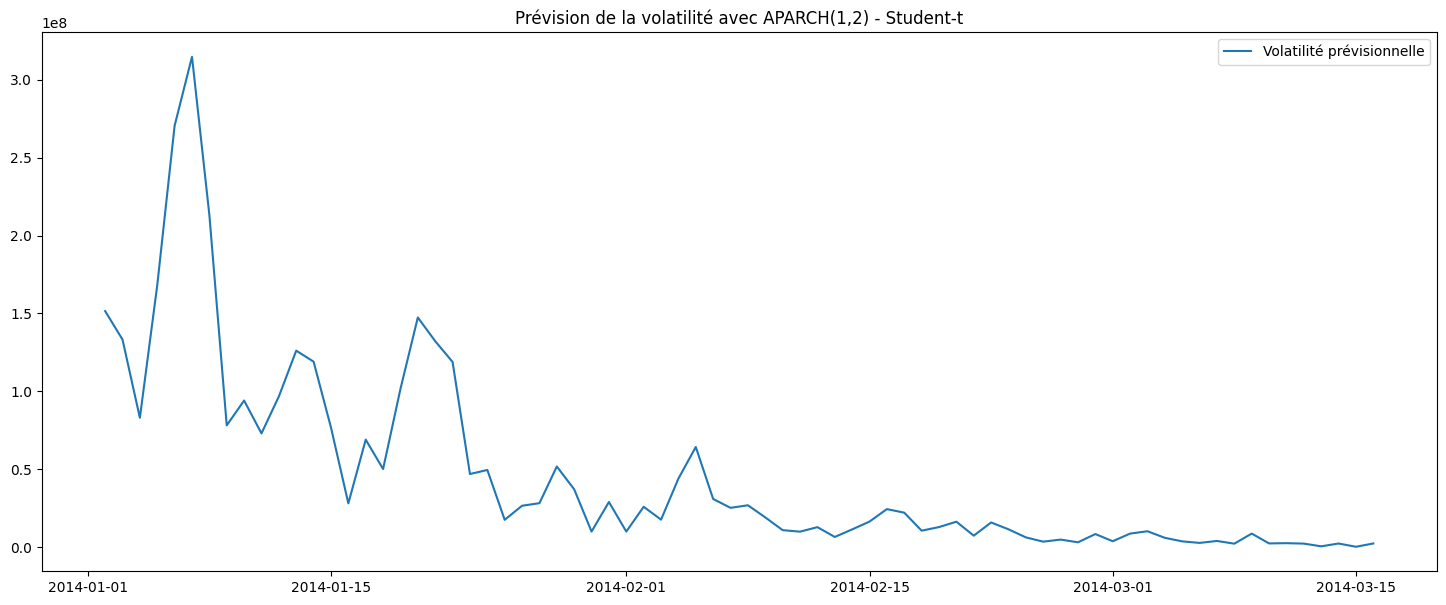

In [ ]:
# Modèle APARCH(1,2) avec loi de Student-t
aparch_model = arch_model(residuals, vol='APARCH', p=100, q=100, dist='t')
aparch_fit = aparch_model.fit()

# Résumé du modèle
#print(aparch_fit.summary())

# Prédiction de la volatilité
aparch_forecast = aparch_fit.forecast(start=0)

plt.figure(figsize=(18,7))
plt.plot(aparch_forecast.variance, label="Volatilité prévisionnelle")
plt.legend()
plt.title('Prévision de la volatilité avec APARCH(1,2) - Student-t')
plt.show()

In [ ]:
# Modèle FIGARCH(1,2) avec loi de Student-t
figarch_model = arch_model(residuals, vol='FIGARCH', p=60, q=0, dist='t')
figarch_fit = figarch_model.fit()

# Résumé du modèle
print(figarch_fit.summary())

# Prédiction de la volatilité
figarch_forecast = figarch_fit.forecast(start=0)

plt.figure(figsize=(18,7))
plt.plot(figarch_forecast.variance, label="Volatilité prévisionnelle")
plt.legend()
plt.title('Prévision de la volatilité avec FIGARCH(1,2) - Student-t')
plt.show()


ValueError: p and q must be either 0 or 1.

In [ ]:
import pandas as pd


df_sales = pd.read_csv("https://raw.githubusercontent.com/dorian68/repo_data/refs/heads/main/orders_train2014-04-05.txt")

# Agréger les données de vente par date
tcd_sales = pd.pivot_table(df_sales, index=['orderDate'], values=['price'], aggfunc=sum)
df_sales = tcd_sales.reset_index()
df_sales.set_index('orderDate', inplace=True)

# Nettoyage des données
data = df_sales
data = data.dropna()  # Supprime les NaN
data.index = pd.to_datetime(data.index)  # Convertit l'index en datetime

<ipython-input-2-9217584db314>:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tcd_sales = pd.pivot_table(df_sales, index=['orderDate'], values=['price'], aggfunc=sum)


In [ ]:
data

,value
date,
2020-01-01,-0.753081
2020-01-02,0.478213
2020-01-03,-0.966783
2020-01-04,-2.379824
2020-01-05,-3.032006
...,...
2020-04-05,-10.490988
2020-04-06,-11.543418
2020-04-07,-11.228113


XGBOOST et LSTM

In [ ]:
# Imports nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Préparation des données pour XGBoost
def prepare_xgboost_data(data, lag=5):
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['value'].shift(i)
    df.dropna(inplace=True)
    X = df.drop(columns=['value'])
    y = df['value']
    return train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_test, y_train, y_test = prepare_xgboost_data(data)

# Entraînement du modèle XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Préparation des données pour LSTM
def prepare_lstm_data(data, look_back=5):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(data_scaled) - look_back):
        X.append(data_scaled[i:i+look_back, 0])
        y.append(data_scaled[i+look_back, 0])
    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.5, shuffle=False), scaler

(X_train, X_test, y_train, y_test), scaler = prepare_lstm_data(data)

# Reshape pour LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construction du modèle LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step - loss: 0.1685
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1461
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1329
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1138
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1061
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0766
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0755
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0608
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0608
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0496
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0417
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0320
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0241
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━

In [ ]:
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


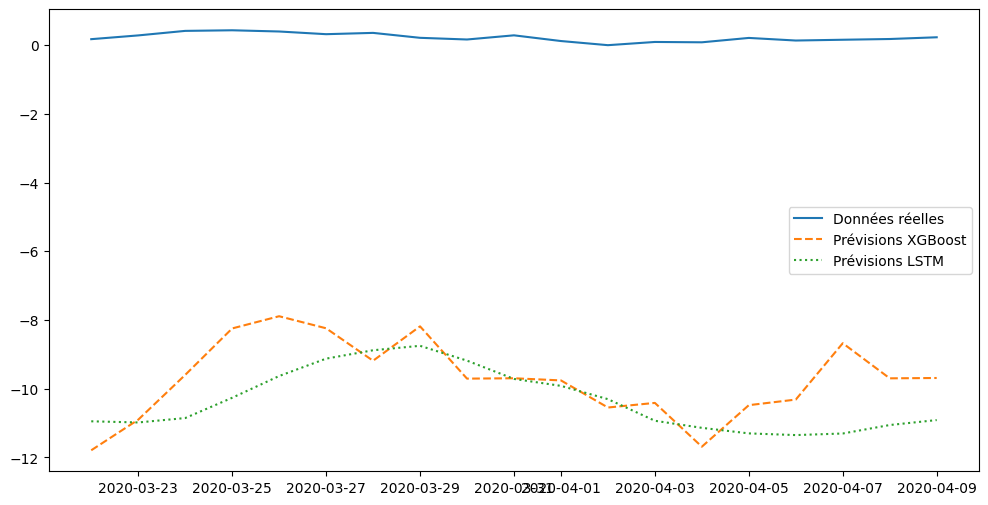

In [ ]:
# Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Données réelles')
plt.plot(data.index[-len(y_test):], xgb_predictions, label='Prévisions XGBoost', linestyle='dashed')
plt.plot(data.index[-len(y_test):], lstm_predictions, label='Prévisions LSTM', linestyle='dotted')
plt.legend()
plt.show()